In [1]:
def get_stratified_subset(df, label_column, num_examples_per_label, random_state=None):
    """
    Returns a stratified subset of the dataframe with a fixed number of examples for each label.

    Args:
        df (pd.DataFrame): The input dataframe.
        label_column (str): The name of the column containing the labels.
        num_examples_per_label (int): The fixed number of examples to sample for each label.
        random_state (int, optional): Random seed for reproducibility.

    Returns:
        pd.DataFrame: A stratified subset of the dataframe.
    """
    if random_state is not None:
        np.random.seed(random_state)

    stratified_subset = []

    for label in df[label_column].unique():
        # label_group = df[df[label_column] == label]
        if len(label_group) < num_examples_per_label:
            raise ValueError(f"Not enough examples for label '{label}'. Requested {num_examples_per_label}, but only {len(label_group)} available.")
        
        sampled_group = label_group.sample(n=num_examples_per_label, random_state=random_state)
        stratified_subset.append(sampled_group)

    return pd.concat(stratified_subset).reset_index(drop=True)

from collections import Counter

def get_majority_vote(dataframes_list):
    """
    Takes a list of dataframes with 'FileName' and 'Prediction' columns and returns
    a new dataframe with majority vote predictions for each filename.
    
    Args:
        dataframes_list (list): List of pandas dataframes, each containing 'FileName' and 'Prediction' columns
        
    Returns:
        pandas.DataFrame: A dataframe with majority vote predictions
    """
    # Concatenate all dataframes
    combined_df = pd.concat(dataframes_list, ignore_index=True)
    
    # Function to get majority vote for a group
    def majority_vote(group):
        predictions = group['Prediction'].tolist()
        # Get the most common prediction
        most_common = Counter(predictions).most_common(1)[0][0]
        return most_common
    
    # Group by FileName and apply majority vote
    result_df = (combined_df.groupby('Filename')
                          .apply(majority_vote)
                          .reset_index())
    
    # Rename the columns
    result_df.columns = ['Filename', 'Prediction']
    
    # Sort by FileName for consistency
    result_df = result_df.sort_values('Filename').reset_index(drop=True)
    
    return result_df

def get_probability_vote(dataframes_list):
    """
    Takes a list of dataframes with 'FileName' and 'class_N_prob' columns
    and returns a new dataframe with FileName and Prediction based on averaged probabilities.
    
    Args:
        dataframes_list (list): List of pandas dataframes containing 'FileName' 
                               and probability columns ('class_0_prob', 'class_1_prob', etc.)
        
    Returns:
        pandas.DataFrame: A dataframe with FileName and Prediction columns
    """
    # Concatenate all dataframes
    combined_df = pd.concat(dataframes_list, ignore_index=True)
    
    # Find probability columns (class_N_prob)
    prob_columns = [col for col in combined_df.columns if col.startswith('class_') and col.endswith('_prob')]
    
    # Function to get prediction from probabilities
    def get_prediction(group):
        mean_probs = [group[col].mean() for col in prob_columns]
        return np.argmax(mean_probs)
    
    # Group by FileName and get predictions
    result_df = pd.DataFrame({
        'Filename': combined_df['Filename'].unique()
    })
    
    result_df['Prediction'] = (combined_df.groupby('Filename')
                                        .apply(get_prediction)
                                        .values)
    
    # Sort by FileName for consistency
    result_df = result_df.sort_values('Filename').reset_index(drop=True)
    
    return result_df

def softmax(x):
    """
    Compute softmax values for each set of scores in x.
    """
    exp_x = np.exp(x - np.max(x))  # Subtract max for numerical stability
    return exp_x / exp_x.sum()

def get_probability_vote_softmax(dataframes_list):
    """
    Takes a list of dataframes with 'FileName' and 'class_N_prob' columns,
    applies softmax to probabilities before averaging, and returns predictions.
    
    Args:
        dataframes_list (list): List of pandas dataframes containing 'FileName' 
                               and probability columns ('class_0_prob', 'class_1_prob', etc.)
        
    Returns:
        pandas.DataFrame: A dataframe with FileName and Prediction columns
    """
    # Concatenate all dataframes
    combined_df = pd.concat(dataframes_list, ignore_index=True)
    
    # Find probability columns (class_N_prob)
    prob_columns = [col for col in combined_df.columns if col.startswith('class_') and col.endswith('_prob')]
    
    # Function to get prediction from probabilities with softmax
    def get_softmax_prediction(group):
        # Get raw probabilities for each prediction
        raw_probs = np.array([group[col].values for col in prob_columns]).T
        
        # Apply softmax to each prediction
        softmax_probs = np.array([softmax(pred) for pred in raw_probs])
        
        # Average the softmaxed probabilities
        mean_probs = softmax_probs.mean(axis=0)
        
        return np.argmax(mean_probs)
    
    # Group by FileName and get predictions
    result_df = pd.DataFrame({
        'Filename': combined_df['Filename'].unique()
    })
    
    result_df['Prediction'] = (combined_df.groupby('Filename')
                                        .apply(get_softmax_prediction)
                                        .values)
    
    # Sort by FileName for consistency
    result_df = result_df.sort_values('Filename').reset_index(drop=True)
    
    return result_df

In [2]:
import pandas as pd
import numpy as np

In [208]:
# Experiments with 1 head
experiments_list =[
    "multimodalmodel_w2v2robust_robertalarge_lazyload_lr1e4_head1",
    "multimodalmodel_hubertxlarge_robertalarge_lazyload_lr1e4_head1",
    "multimodalmodel_w2v2xls2b_robertalarge_lazyload_lr1e4_head1",
    "multimodalmodel_whisperlarge_robertalarge_lazyload_lr1e4_1head",
    "multimodalmodel_wavlmlarge_robertalarge_lazyload_lr1e4_head1",
    "multimodalmodel_whisperlarge_debertaxxlarge_lazyload_lr1e5_lasthidden_head1",
    "multimodalmodel_whisperlarge_hubertxlarge_lazyload_lr1e4_head1",
    "multimodalmodel_whisperlarge_robertalarge_lazyload_lr1e4_1head_prodosyembs",
    "multimodalmodel_hubertxlarge_robertalarge_lazyload_lr1e4_head1_rankingloss",
    "multimodalmodel_w2v2xls2b_robertalarge_lazyload_lr1e4_head1_rankingloss",
    "multimodalmodel_w2v2robust_robertalarge_lazyload_lr1e4_head1_rankingloss",
    "multimodalmodel_whisperlarge_debertaxxlarge_lazyload_lr1e5_lasthidden_head1_rankingloss",
    "multimodalmodel_whisperlarge_robertalarge_lazyload_lr1e4_1head_rankingloss",
    "multimodalmodel_wavlmlarge_robertalarge_lazyload_lr1e4_head1_softlossneutral",
    "multimodalmodel_whisperlarge_hubertxlarge_lazyload_lr1e4_head1_rankingloss",
    "multimodalmodel_whisperlarge_robertalarge_lazyload_lr1e4_1head_prodosyembs_rankingloss"
]

dfs = []

for exp in experiments_list:
    
    dfs.append(pd.read_csv(f'../experiments/{exp}/results/dev.csv'))
# preds.head()

In [209]:
preds = get_majority_vote(dfs)

In [225]:
preds = get_probability_vote(dfs)
# preds = get_probability_vote_softmax(dfs)
classes_ = ['A', 'S', 'H', 'U', 'F', 'D', 'C', 'N']

map_argmax = dict()
for i, c in enumerate(classes_):
    map_argmax[i] = c

preds["Prediction"] = preds["Prediction"].map(map_argmax) 

In [226]:
preds.head()

,Filename,Prediction
0,MSP-PODCAST_0002_0033.wav,N
1,MSP-PODCAST_0002_0039.wav,N
2,MSP-PODCAST_0002_0051.wav,N
3,MSP-PODCAST_0002_0061.wav,C
4,MSP-PODCAST_0006_0017.wav,N


In [227]:
df = pd.read_csv('/workspace/lucas.ueda/interspeech_ser/data/Labels/labels_consensus.csv')
df.head()

,FileName,EmoClass,EmoAct,EmoVal,EmoDom,SpkrID,Gender,Split_Set
0,MSP-PODCAST_0002_0033.wav,N,4.8,4.2,5.4,127,Female,Development
1,MSP-PODCAST_0002_0039.wav,N,4.0,4.2,4.2,127,Female,Development
2,MSP-PODCAST_0002_0051.wav,N,4.0,4.2,4.2,127,Female,Development
3,MSP-PODCAST_0002_0059.wav,X,4.0,3.8,4.0,128,Female,Development
4,MSP-PODCAST_0002_0061.wav,F,3.4,2.8,4.2,128,Female,Development


In [228]:
preds['FileName'] = preds['Filename']
preds = preds.merge(df[['FileName','EmoClass','Gender','SpkrID']], how='left', on = 'FileName')

In [229]:
preds['EmoClass'].isnull().sum()

0

In [230]:
preds.head()

,Filename,Prediction,FileName,EmoClass,Gender,SpkrID
0,MSP-PODCAST_0002_0033.wav,N,MSP-PODCAST_0002_0033.wav,N,Female,127
1,MSP-PODCAST_0002_0039.wav,N,MSP-PODCAST_0002_0039.wav,N,Female,127
2,MSP-PODCAST_0002_0051.wav,N,MSP-PODCAST_0002_0051.wav,N,Female,127
3,MSP-PODCAST_0002_0061.wav,C,MSP-PODCAST_0002_0061.wav,F,Female,128
4,MSP-PODCAST_0006_0017.wav,N,MSP-PODCAST_0006_0017.wav,N,Female,127


In [231]:
# !pip install matplotlib

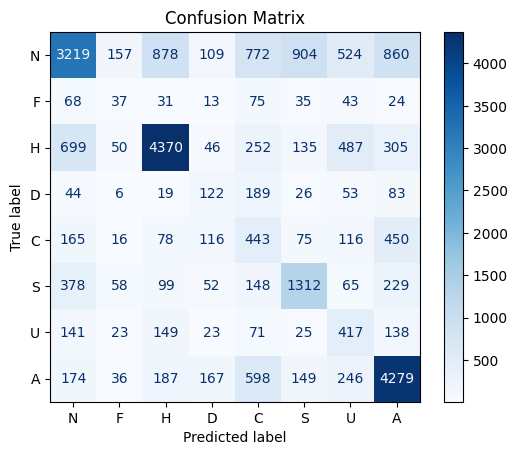

In [232]:
import pandas as pd
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, f1_score
import matplotlib.pyplot as plt

# Generate confusion matrix
cm = confusion_matrix(preds['EmoClass'], preds['Prediction'], labels=preds['EmoClass'].unique())

# Display labels
labels = preds['EmoClass'].unique()

# Visualize confusion matrix
cmd = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
cmd.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

In [233]:
preds_subset = get_stratified_subset(preds, 'EmoClass', 100)
preds_subset.head()

,Filename,Prediction,FileName,EmoClass,Gender,SpkrID
0,MSP-PODCAST_2421_0197.wav,S,MSP-PODCAST_2421_0197.wav,N,Female,210
1,MSP-PODCAST_2347_1004.wav,A,MSP-PODCAST_2347_1004.wav,N,Female,210
2,MSP-PODCAST_3406_0004_0003.wav,N,MSP-PODCAST_3406_0004_0003.wav,N,Male,1767
3,MSP-PODCAST_0807_1720.wav,U,MSP-PODCAST_0807_1720.wav,N,Male,97
4,MSP-PODCAST_3079_1429.wav,N,MSP-PODCAST_3079_1429.wav,N,Male,2261


In [234]:
# Average F1-score using bootstrap
f1_scores = []
for i in range(100):
    preds_subset = get_stratified_subset(preds, 'EmoClass', 200, i)
    f1_scores.append(f1_score(preds_subset['EmoClass'], preds_subset['Prediction'], average='macro'))

In [235]:
f1_scores = np.array(f1_scores)

np.mean(f1_scores), np.std(f1_scores),np.max(f1_scores),np.min(f1_scores)

(0.4143120159853909,
 0.01016979723071277,
 0.44036108293538334,
 0.3865426218246341)

In [236]:
f1_scores = np.array(f1_scores)

np.mean(f1_scores), np.std(f1_scores),np.max(f1_scores),np.min(f1_scores)

(0.4143120159853909,
 0.01016979723071277,
 0.44036108293538334,
 0.3865426218246341)

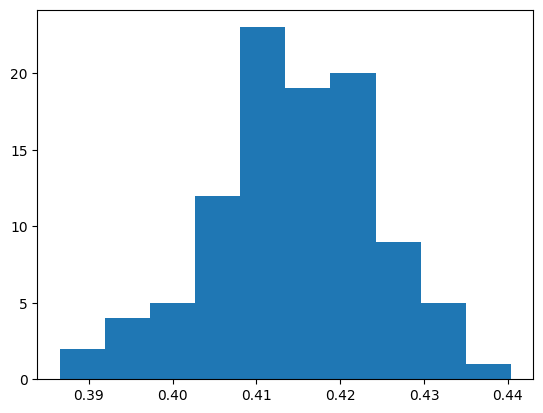

In [237]:
plt.hist(f1_scores, bins=10)
plt.show()

In [238]:
f1_score(preds['EmoClass'], preds['Prediction'], average='macro')

0.41027778446751095

In [239]:
f1_score(preds['EmoClass'], preds['Prediction'], average='micro')

0.5621585240319898

In [240]:
accuracy_score(preds['EmoClass'], preds['Prediction'])

0.5621585240319898

In [241]:
preds['PRED_dumb'] = 'N'
f1_score(preds['EmoClass'], preds['PRED_dumb'], average='macro'), accuracy_score(preds['EmoClass'], preds['PRED_dumb'])

(0.05678375814693552, 0.2938870852799113)

In [242]:
preds['EmoClass'].value_counts()

EmoClass
N    7423
H    6344
A    5836
S    2341
C    1459
U     987
D     542
F     326
Name: count, dtype: int64

In [243]:
preds.head(2)

,Filename,Prediction,FileName,EmoClass,Gender,SpkrID,PRED_dumb
0,MSP-PODCAST_0002_0033.wav,N,MSP-PODCAST_0002_0033.wav,N,Female,127,N
1,MSP-PODCAST_0002_0039.wav,N,MSP-PODCAST_0002_0039.wav,N,Female,127,N


In [244]:
f1_score(preds[preds['Gender']=='Female']['EmoClass'], preds[preds['Gender']=='Female']['Prediction'], average='macro')

0.3798874954391974

In [245]:
f1_score(preds[preds['Gender']=='Male']['EmoClass'], preds[preds['Gender']=='Male']['Prediction'], average='macro')

0.4343737384089837

In [246]:
accuracy_score(preds[preds['Gender']=='Female']['EmoClass'], preds[preds['Gender']=='Female']['Prediction'])

0.49762699947266653

In [247]:
accuracy_score(preds[preds['Gender']=='Male']['EmoClass'], preds[preds['Gender']=='Male']['Prediction'])

0.6150576368876081

In [248]:
for e in preds['EmoClass'].unique():
    acc = accuracy_score(preds[preds['EmoClass']==e]['EmoClass'], preds[preds['EmoClass']==e]['Prediction'])
    print(f'Emotion {e} acc = {acc}')

Emotion N acc = 0.433652162198572
Emotion F acc = 0.11349693251533742
Emotion H acc = 0.6888398486759143
Emotion D acc = 0.22509225092250923
Emotion C acc = 0.3036326250856751
Emotion S acc = 0.5604442545920547
Emotion U acc = 0.42249240121580545
Emotion A acc = 0.7332076764907471


In [249]:
preds.groupby('SpkrID').agg({'Gender': 'count'}).reset_index().sort_values(by='Gender', ascending= False).head(10)

,SpkrID,Gender
17,210,3400
5,97,1371
610,2789,1135
4,54,444
281,2027,390
611,2794,353
623,2951,347
15,169,347
0,26,312
13,149,296


In [146]:
top10_volumetry_spks = preds.groupby('SpkrID').agg({'Gender': 'count'}).reset_index().sort_values(by='Gender', ascending= False).head(10).SpkrID

In [147]:
for spk in top10_volumetry_spks:
    emotions_spk = preds[preds['SpkrID']==spk]['EmoClass'].unique()
    gender = preds[preds['SpkrID']==spk]['Gender'].values[0]
    acc = accuracy_score(preds[preds['SpkrID']==spk]['EmoClass'], preds[preds['SpkrID']==spk]['Prediction'])
    f1_ = f1_score(preds[preds['SpkrID']==spk]['EmoClass'], preds[preds['SpkrID']==spk]['Prediction'], average='macro')
    print(f'Spk {spk} (Gender = {gender}) has emotions = {emotions_spk} with acc = {acc} f1-macro = {f1_}')

Spk 210 (Gender = Female) has emotions = ['F' 'S' 'N' 'D' 'C' 'A' 'U' 'H'] with acc = 0.3035294117647059 f1-macro = 0.23576131759490698
Spk 97 (Gender = Male) has emotions = ['H' 'C' 'N' 'D' 'U' 'A' 'F' 'S'] with acc = 0.4762946754194019 f1-macro = 0.3355300281283211
Spk 2789 (Gender = Male) has emotions = ['C' 'A' 'H' 'N' 'S' 'U' 'D'] with acc = 0.8581497797356828 f1-macro = 0.26593091006215425
Spk 54 (Gender = Male) has emotions = ['H' 'N' 'D' 'C' 'A' 'F' 'U'] with acc = 0.4797297297297297 f1-macro = 0.3603898775529361
Spk 2027 (Gender = Male) has emotions = ['A' 'C' 'N' 'H' 'S' 'U' 'D'] with acc = 0.7076923076923077 f1-macro = 0.26229780764900734
Spk 2794 (Gender = Male) has emotions = ['H' 'S' 'N' 'A' 'U'] with acc = 0.7138810198300283 f1-macro = 0.3696589588384512
Spk 2951 (Gender = Male) has emotions = ['H' 'N' 'A' 'S' 'C' 'U'] with acc = 0.8126801152737753 f1-macro = 0.36582723429797065
Spk 169 (Gender = Male) has emotions = ['H' 'N' 'C' 'A' 'U' 'S' 'D' 'F'] with acc = 0.3631123

In [148]:
for spk in top10_volumetry_spks:
    df_filt = preds[preds['SpkrID']==spk]
    gender = df_filt.Gender.values[0]
    for e in df_filt['EmoClass'].unique():
        acc = accuracy_score(df_filt[df_filt['EmoClass']==e]['EmoClass'], df_filt[df_filt['EmoClass']==e]['Prediction'])
        print(f'SPK {spk} (gender = {gender}) in emotion {e} acc = {acc}')

SPK 210 (gender = Female) in emotion F acc = 0.015151515151515152
SPK 210 (gender = Female) in emotion S acc = 0.4251968503937008
SPK 210 (gender = Female) in emotion N acc = 0.15833333333333333
SPK 210 (gender = Female) in emotion D acc = 0.36046511627906974
SPK 210 (gender = Female) in emotion C acc = 0.2894736842105263
SPK 210 (gender = Female) in emotion A acc = 0.48882410106899904
SPK 210 (gender = Female) in emotion U acc = 0.2804878048780488
SPK 210 (gender = Female) in emotion H acc = 0.28378378378378377
SPK 97 (gender = Male) in emotion H acc = 0.649090909090909
SPK 97 (gender = Male) in emotion C acc = 0.4017094017094017
SPK 97 (gender = Male) in emotion N acc = 0.40730337078651685
SPK 97 (gender = Male) in emotion D acc = 0.36
SPK 97 (gender = Male) in emotion U acc = 0.35251798561151076
SPK 97 (gender = Male) in emotion A acc = 0.27472527472527475
SPK 97 (gender = Male) in emotion F acc = 0.05555555555555555
SPK 97 (gender = Male) in emotion S acc = 0.14285714285714285
SPK 

# Dimensional

In [26]:
!ls ../benchmark/model/dim_ser/7/results

dev.csv  test3.csv


In [27]:
preds = pd.read_csv('../benchmark/model/dim_ser/7/results/dev.csv')
preds.head()

,FileName,EmoAct,EmoVal,EmoDom
0,MSP-PODCAST_0002_0033.wav,4.110488,3.377474,4.107728
1,MSP-PODCAST_0002_0039.wav,4.309968,3.705411,4.469491
2,MSP-PODCAST_0002_0051.wav,3.757301,4.351225,4.176206
3,MSP-PODCAST_0002_0059.wav,4.127300,3.831695,4.195695
4,MSP-PODCAST_0002_0061.wav,4.053204,3.987261,4.183712


In [28]:
df = pd.read_csv('/workspace/lucas.ueda/interspeech_ser/data/Labels/labels_consensus.csv')
df.head(2)

,FileName,EmoClass,EmoAct,EmoVal,EmoDom,SpkrID,Gender,Split_Set
0,MSP-PODCAST_0002_0033.wav,N,4.8,4.2,5.4,127,Female,Development
1,MSP-PODCAST_0002_0039.wav,N,4.0,4.2,4.2,127,Female,Development


In [47]:
preds = preds.merge(df[['FileName','EmoAct','EmoVal','EmoDom']], how='left', on = 'FileName')

In [49]:
preds.head(2)

,FileName,EmoAct_x,EmoVal_x,EmoDom_x,EmoAct_y,EmoVal_y,EmoDom_y
0,MSP-PODCAST_0002_0033.wav,4.110488,3.377474,4.107728,4.8,4.2,5.4
1,MSP-PODCAST_0002_0039.wav,4.309968,3.705411,4.469491,4.0,4.2,4.2


In [48]:
import torch
def CCC_loss(pred, lab, m_lab=None, v_lab=None, is_numpy=True):
    """
    pred: (N, 3)
    lab: (N, 3)
    """
    if is_numpy:
        pred = torch.Tensor(pred).float()
        lab = torch.Tensor(lab).float()
    
    m_pred = torch.mean(pred, 0, keepdim=True)
    m_lab = torch.mean(lab, 0, keepdim=True)

    d_pred = pred - m_pred
    d_lab = lab - m_lab

    v_pred = torch.var(pred, 0, unbiased=False)
    v_lab = torch.var(lab, 0, unbiased=False)

    corr = torch.sum(d_pred * d_lab, 0) / (torch.sqrt(torch.sum(d_pred ** 2, 0)) * torch.sqrt(torch.sum(d_lab ** 2, 0)))

    s_pred = torch.std(pred, 0, unbiased=False)
    s_lab = torch.std(lab, 0, unbiased=False)

    ccc = (2*corr*s_pred*s_lab) / (v_pred + v_lab + (m_pred[0]-m_lab[0])**2)    
    return ccc

In [54]:
CCC_loss(preds[['EmoAct_x','EmoVal_x','EmoDom_x']].values,preds[['EmoAct_y','EmoVal_y','EmoDom_y']].values)

tensor([0.6949, 0.7050, 0.6312])

In [55]:
preds['EmoAct_d'] = preds['EmoAct_y'].mean() 
preds['EmoVal_d'] = preds['EmoVal_y'].mean() 
preds['EmoDom_d'] = preds['EmoDom_y'].mean() 

In [56]:
CCC_loss(preds[['EmoAct_d','EmoVal_d','EmoDom_d']].values,preds[['EmoAct_y','EmoVal_y','EmoDom_y']].values)

tensor([-0., -0., -0.])